In [ ]:
import sklearn as sk
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')

In [ ]:
cp drive/MyDrive/data/millenium/* ./

In [ ]:
df_train = pd.read_csv('train.csv', header=None)
df_test  = pd.read_csv('test.csv', header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.826575,0.843082,0.805944,0.785864,0.772749,0.854208,0.863394,0.816732,0.829742,0.776793,0.779615,0.796459,0.838491,0.792806,0.842058,0.757744,0.698764,0.847413,0.744884,0.764534,0.905775,0.810743,0.574111,0.664428,0.838431,0.751858,0.753316,0.849535,0.303032,0.339511,0.499761,0.582015,0.686515,0.457332,0.587442,0.484111,0.491995,0.611001,0.607850,0.582491,...,0.113304,0.141189,0.040872,0.046161,0.036707,0.052664,0.029926,0.134130,0.102104,0.073610,0.038518,0.025130,0.015412,0.122872,0.158462,0.129839,0.163791,0.127901,0.176722,0.099130,0.443695,0.382850,0.355990,0.414432,0.317461,0.189214,0.269183,0.016788,0.013705,0.012601,0.010687,0.010919,0.011375,0.015069,0,0,0,1,0,1
1,0.766867,0.669694,0.636238,0.612133,0.639010,0.603999,0.583958,0.775580,0.815867,0.676433,0.656098,0.753844,0.674493,0.631642,0.738733,0.813003,0.730447,0.670668,0.677323,0.748249,0.693352,0.782133,0.805960,0.743947,0.611240,0.632528,0.812389,0.637667,0.475344,0.535699,0.592320,0.598006,0.672811,0.615974,0.580945,0.569229,0.594587,0.555721,0.549745,0.510593,...,0.027936,0.007563,0.151871,0.070208,0.242322,0.019004,0.014358,0.050794,0.123046,0.107319,0.046706,0.041851,0.082779,0.119522,0.114285,0.052862,0.069018,0.034819,0.132430,0.190853,0.043030,0.035736,0.044215,0.055009,0.078913,0.175919,0.223353,0.041061,0.050408,0.051189,0.050673,0.055661,0.079765,0.097522,0,0,0,1,0,1
2,0.962784,0.975387,0.963950,0.955206,0.956827,0.971538,0.975437,0.934207,0.858234,0.742964,0.839465,0.765593,0.926303,0.982745,0.950932,0.856413,0.718964,0.850750,0.785884,0.922892,0.988171,0.944247,0.840710,0.713282,0.826791,0.720847,0.876573,0.980914,0.794011,0.756979,0.640517,0.671108,0.659003,0.649349,0.606420,0.689294,0.691110,0.613118,0.626651,0.501959,...,0.032828,0.004701,0.010187,0.004174,0.005082,0.001456,0.001563,0.032216,0.007985,0.015745,0.068779,0.060035,0.001721,0.165198,0.206641,0.362920,0.261239,0.182758,0.109762,0.146467,0.302947,0.288413,0.260631,0.233557,0.209348,0.169218,0.337669,0.083091,0.187438,0.532243,0.232948,0.195177,0.221791,0.201402,0,0,0,1,0,1
3,0.758844,0.772668,0.791800,0.827195,0.861022,0.755208,0.669177,0.754382,0.675287,0.773369,0.757682,0.688823,0.710866,0.766792,0.539873,0.439877,0.713732,0.610776,0.575085,0.472539,0.596526,0.442304,0.506889,0.561051,0.500253,0.507535,0.405099,0.509126,0.366228,0.464582,0.498804,0.463746,0.472523,0.354860,0.452510,0.445907,0.380059,0.624031,0.524873,0.494068,...,0.385792,0.296004,0.267557,0.694374,0.134737,0.222545,0.154248,0.340014,0.336629,0.291258,0.641324,0.325588,0.192433,0.134867,0.202801,0.249167,0.197432,0.439424,0.236846,0.148564,0.262371,0.262888,0.208767,0.171912,0.370191,0.084081,0.145852,0.148042,0.211724,0.115635,0.297193,0.254088,0.221800,0.146297,0,0,1,0,0,0
4,0.767603,0.875207,0.866511,0.874739,0.818681,0.826858,0.842438,0.773873,0.877341,0.867682,0.761296,0.695048,0.654743,0.685375,0.684643,0.781965,0.834847,0.774313,0.639332,0.592065,0.489529,0.465693,0.549283,0.508727,0.507610,0.520886,0.610026,0.649071,0.377131,0.388111,0.363016,0.497978,0.512576,0.445695,0.507468,0.420926,0.385721,0.525330,0.562466,0.540347,...,0.284830,0.176423,0.159641,0.199182,0.306721,0.289498,0.233314,0.258575,0.208342,0.171501,0.142715,0.377999,0.476940,0.161439,0.179262,0.075553,0.315224,0.159809,0.151944,0.189172,0.643637,0.301675,0.620394,0.424268,0.442008,0.347993,0.256008,0.166874,0.100561,0.157648,0.129825,0.075116,0.060953,0.022725,0,0,1,0,0,0


In [ ]:
X = np.array(df_train.iloc[:, :-6])
y = np.array(df_train.iloc[:, -6:])
mu, sigma = X.mean(0), X.std(0)
X = (X - mu) / sigma

## Data Analysis
Lets look at the correlation between output variables and the correlation between outputs with inputs.

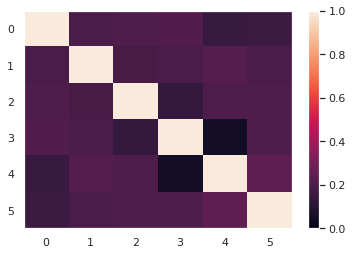

In [ ]:
y_corr = np.array(df_train.iloc[:,-6:].corr())
plt.imshow(abs(y_corr), interpolation='nearest', aspect='auto')
plt.grid()
plt.clim(0, 1)
plt.colorbar()
plt.show()

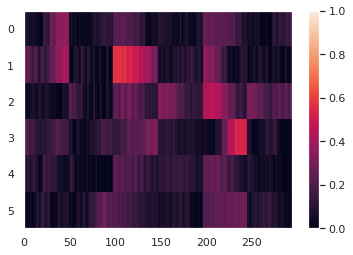

In [ ]:
corr = np.array(df_train.corr().iloc[-6:,:-6])
plt.imshow(abs(corr), interpolation='nearest', aspect='auto')
plt.grid()
plt.clim(0, 1)
plt.colorbar()
plt.show()

- As we can observe from these plots, the output variables have some correlation between the, so it would make sense to predict each of them using a single multi-label classifier model rather than an independent model for each class. I have trid both methods below

- We can see that most variables aren't very highly correlated, hence performing dimension reduction can hurt performance. So I'm skipping this step.



In [ ]:
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

---
I am using a collection of XGBclassifiers for predicting each variable sperately

In [ ]:
model = xgb.XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.5)
multi_xgb = MultiOutputClassifier(model)
multi_xgb.fit(X_train, y_train)
y_pred = multi_xgb.predict(X_test)
print("Classification Report")
print(classification_report(y_test, y_pred))
print(f"Accuracy = {100*multi_xgb.score(X_test, y_test):.02f}%")

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        50
           1       0.90      0.86      0.88        44
           2       0.84      0.77      0.80        47
           3       0.89      0.81      0.85        52
           4       0.70      0.37      0.48        63
           5       0.81      0.58      0.67        52

   micro avg       0.84      0.66      0.74       308
   macro avg       0.84      0.68      0.74       308
weighted avg       0.83      0.66      0.73       308
 samples avg       0.67      0.68      0.66       308

Accuracy = 60.42%


---
I'm using a deep neural network for predicting the 6 output variables using same model in end-to-end fashion.

In [ ]:
nn = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=50, early_stopping=True,
                   solver='adam', learning_rate='adaptive')
nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)
print("Classification Report")
print(classification_report(y_test, y_pred))
print(f"Accuracy = {100*nn.score(X_test, y_test):.02f}%")

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.68      0.77        50
           1       0.83      0.86      0.84        44
           2       0.79      0.81      0.80        47
           3       0.82      0.79      0.80        52
           4       0.66      0.49      0.56        63
           5       0.79      0.52      0.63        52

   micro avg       0.79      0.68      0.73       308
   macro avg       0.80      0.69      0.74       308
weighted avg       0.79      0.68      0.73       308
 samples avg       0.70      0.70      0.69       308

Accuracy = 63.54%


In [ ]:
X_infer = np.array(df_test)
X_infer = (X_infer - mu) / sigma
y_infer = nn.predict(X_infer)

In [ ]:
with open('out.csv', 'w') as f:
    for y in y_infer:
        s = ', '.join(str(i) for i in y)+'\n'
        f.write(s)

In [ ]:
!wc -l out.csv

966 out.csv


In [ ]:
svm = SVC(gamma='auto')
multi_svm = MultiOutputClassifier(svm)
multi_svm.fit(X_train, y_train)
y_pred = multi_svm.predict(X_test)
print("Classification Report")
print(classification_report(y_test, y_pred))
print(f"Accuracy = {100*multi_svm.score(X_test, y_test):.02f}%")

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.52      0.67        50
           1       0.95      0.91      0.93        44
           2       0.84      0.79      0.81        47
           3       0.95      0.79      0.86        52
           4       0.87      0.41      0.56        63
           5       0.82      0.52      0.64        52

   micro avg       0.90      0.64      0.75       308
   macro avg       0.89      0.66      0.74       308
weighted avg       0.89      0.64      0.73       308
 samples avg       0.67      0.66      0.66       308

Accuracy = 62.15%


array([[-0.2222527 , -0.448964  , -0.67316331, ..., -0.67233147,
        -0.71729715, -0.70301759],
       [ 1.12228861,  1.27393315,  1.24624433, ...,  0.02734189,
        -0.12957995,  0.09558073],
       [-0.14199451,  0.63730552,  0.9999504 , ..., -0.65676689,
        -0.60241037, -0.50141601],
       ...,
       [ 0.3347075 , -1.13215532, -1.27569549, ..., -0.49892888,
        -0.54592663, -0.54385915],
       [ 1.57441504,  1.47911187,  1.28462934, ..., -0.3025834 ,
         0.02643628,  1.45444437],
       [ 0.64518466,  0.39242102,  0.23990115, ..., -0.41982197,
         0.00986182, -0.16686618]])